In [2]:
import os
import sys
import pickle
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from ms2deepscore import SpectrumBinner
from ms2deepscore.models import SiameseModel

ROOT = os.path.dirname(os.getcwd())
sys.path.insert(0, ROOT)
path_data = 'C:\\OneDrive - Netherlands eScience Center\\Project_Wageningen_iOMEGA\\Data\\'

### Load annotated spectrums

In [3]:
filename = os.path.join(path_data, 'GNPS_all', 'ALL_GNPS_210125_positive_processed_annotated.pickle')
with open(filename, 'rb') as file:
    spectrums = pickle.load(file)

print(f"{len(spectrums)} spectra imported.")

109734 spectra imported.


In [4]:
from matchms.utils import is_valid_inchikey

inchikey_count = 0
for spec in spectrums:
    if is_valid_inchikey(spec.get("inchikey")):
        inchikey_count += 1

print(f"Found {inchikey_count} spectrums with inchikey")

Found 109734 spectrums with inchikey


### Created binned spectrums

(0.0, 1000.0)

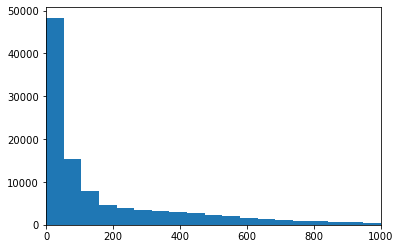

In [11]:
numbers_of_peaks = [len(s.peaks) for s in spectrums]
plt.hist(numbers_of_peaks, np.linspace(0,1000,20))
plt.xlim(0, 1000)

In [16]:
np.min(np.array(numbers_of_peaks)), np.max(np.array(numbers_of_peaks))

(5, 37922)

## Remove very small peaks (<0.001 max intensity)

In [5]:
from matchms.filtering import reduce_to_number_of_peaks
from matchms.filtering import select_by_relative_intensity

def process_peaks(s):
    s = select_by_relative_intensity(s, intensity_from=0.001)
    s = reduce_to_number_of_peaks(s, n_max=1000)
    return s
    
spectrums = [process_peaks(s) for s in spectrums]

1 1000


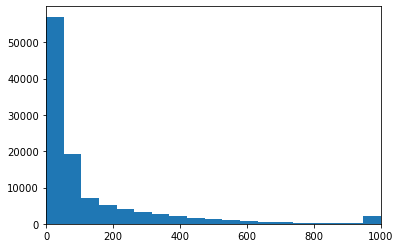

In [8]:
numbers_of_peaks = [len(s.peaks) for s in spectrums]
plt.hist(numbers_of_peaks, np.linspace(0,1000,20))
plt.xlim(0, 1000)

print(np.min(np.array(numbers_of_peaks)), np.max(np.array(numbers_of_peaks)))

## Load model

In [8]:
from ms2deepscore.models import load_model

model_file = "ms2ds_siamese_210207_ALL_GNPS_positive_L1L2.hdf5" #"ms2ds_siamese_210210_ALL_GNPS_positive_600_500_500_400.hdf5"
model = load_model(model_file)
model.summary()

Model: "base"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
base_input (InputLayer)      [(None, 9947)]            0         
_________________________________________________________________
dense1 (Dense)               (None, 1000)              9948000   
_________________________________________________________________
normalization1 (BatchNormali (None, 1000)              4000      
_________________________________________________________________
dropout1 (Dropout)           (None, 1000)              0         
_________________________________________________________________
dense2 (Dense)               (None, 700)               700700    
_________________________________________________________________
normalization2 (BatchNormali (None, 700)               2800      
_________________________________________________________________
dropout2 (Dropout)           (None, 700)               0      

In [14]:
binned_spec = model.spectrum_binner.transform([spec])[0]

Spectrum binning: 100%|█████████████| 1/1 [00:00<00:00, 224.07it/s]
Create BinnedSpectrum instances: 100%|█| 1/1 [00:00<00:00, 2014.56i


In [15]:
binned_spec.binned_peaks

{946: 0.11638598286982411,
 1068: 0.09321851972969362,
 1222: 0.057279504269199776,
 1492: 0.06394737697088601,
 1532: 0.0619167815104723,
 1614: 0.10483274831923761,
 1755: 0.06546276575116497,
 1917: 0.059817293851983366,
 2038: 0.06186517506941746,
 2220: 0.0619167815104723,
 2241: 0.11856161008630521,
 2322: 0.11416890395765793,
 2332: 0.059817293851983366,
 2361: 0.06782643584280894,
 2463: 0.08756355215060162,
 2483: 0.08609179099304469,
 2504: 0.13375553528311504,
 2524: 0.11076010592433454,
 2787: 0.06968503848014805,
 2888: 0.07149534094485285,
 2948: 0.06394737697088601,
 2989: 0.07149534094485285,
 3069: 0.09183742827275947,
 3089: 0.0749849461859034,
 3151: 0.0799342212136075,
 3211: 0.10604472786992127,
 3251: 0.06968503848014805,
 3272: 0.13279670187934486,
 3282: 0.095921065456329,
 3312: 0.0985495265131164,
 3343: 0.07826021885777396,
 3353: 0.08609179099304469,
 3372: 0.07149534094485285,
 3373: 0.13272814183724876,
 3376: 0.0619167815104723,
 3545: 0.0619167815104723,

## Compute embeddings

In [19]:
from ms2deepscore import MS2DeepScore
ms2ds_score = MS2DeepScore(model)

In [20]:
from tqdm import tqdm

embeddings = []
for spec in tqdm(spectrums):
    binned_spec = model.spectrum_binner.transform([spec], progress_bar=False)[0]
    embeddings.append(model.base.predict(ms2ds_score._create_input_vector(binned_spec)))
    

  5%|█▏                    | 5721/109734 [06:26<1:57:01, 14.81it/s]


KeyboardInterrupt: 

## Check if faster: do in batches...

In [38]:
from tqdm import tqdm

n_spectrums = len(spectrums)
batch_size = 50
n_batches = int(np.ceil(n_spectrums/batch_size))

# Initialize embeddings array
embeddings = np.zeros((n_spectrums, ms2ds_score.output_vector_dim))

ms2ds_score.progress_bar = False
for count in tqdm(range(n_batches)):
    low = count*batch_size
    high = (count+1)*batch_size
    embeddings[low:high, :] = ms2ds_score.calculate_vectors(spectrums[low:high])

100%|████████████████████████| 2195/2195 [1:44:37<00:00,  2.86s/it]


In [40]:
embeddings.shape

(109734, 400)

In [39]:
np.save("ms2ds_embeddings_model210207_ALL_GNPS_positive_L1L2.npy", embeddings)

In [22]:
spectrum_ids = []
for spec in tqdm(spectrums):
    spectrum_ids.append(spec.get("spectrumid"))

100%|██████████████████| 109734/109734 [00:00<00:00, 599561.73it/s]


In [21]:
# just checking something
for spec in tqdm(spectrums):
    if not spec.get("spectrumid"):
        if spec.get("spectrum id"):
            print(spec.get("spectrum id"))
        else:
            print(spec.metadata)

100%|██████████████████| 109734/109734 [00:00<00:00, 516584.01it/s]


In [42]:
ms2ds_embeddings = pd.DataFrame(embeddings, index=spectrum_ids)
ms2ds_embeddings.head()

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
CCMSLIB00000001547,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,3.476796,20.291985,...,18.685604,0.000000,16.104929,0.0,0.000000,0.0,0.000000,0.0,22.626669,0.000000
CCMSLIB00000001548,0.0,0.0,0.0,0.000000,0.0,0.0,27.889698,0.000000,1.514147,9.358854,...,11.398055,0.000000,6.999692,0.0,0.000000,0.0,20.042799,0.0,21.461294,6.365351
CCMSLIB00000001549,0.0,0.0,0.0,24.830593,0.0,0.0,40.770763,0.000000,0.000000,21.494141,...,2.923690,37.494492,6.250359,0.0,34.624268,0.0,0.000000,0.0,3.956780,0.000000
CCMSLIB00000001550,0.0,0.0,0.0,0.000000,0.0,0.0,30.164677,0.000000,9.577003,21.558676,...,0.000000,0.000000,17.673256,0.0,0.000000,0.0,0.000000,0.0,16.931871,4.567202
CCMSLIB00000001552,0.0,0.0,0.0,5.834791,0.0,0.0,19.156965,9.777411,0.000000,7.137674,...,16.553169,23.736992,6.935493,0.0,35.172691,0.0,0.000000,0.0,19.771908,0.000000


In [ ]:
ms2ds_embeddings.to_csv("ms2ds_embeddings_model210207_ALL_GNPS_positive_L1L2.csv")

In [21]:
pickle.dump(spectrum_binner, 
            open(os.path.join(path_data, 'GNPS_all', 'ALL_GNPS_positive_training_spectrum_binner_1.pickle'), "wb"))
